# Moving MNIST数据导入

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

 Moving MNIST contains 10,000 sequences each of length 20 showing 2 digits moving in a 64 x 64 frame.

In [6]:
def draw_sequence(seq):
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
    for i in range(20):
        r = i // 10
        c = i % 10
        axes[r][c].imshow(seq[i])
    plt.show()

In [4]:
data = np.load('mnist_test_seq.npy')

In [5]:
data.shape

(20, 10000, 64, 64)

In [7]:
data = data / 255

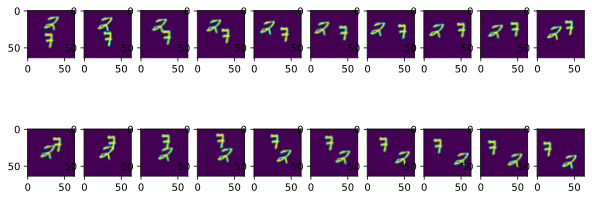

In [8]:
draw_sequence(data[:, 0, :, :])

In [38]:
np.max(data[0, 0, :, :])

1.0

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader # 用于加载训练、验证数据
train_len = 8000
X_train, X_test = data[:10, :8000, :, :], data[:10, 8000:, :, :]
Y_train, Y_test = data[10:, :8000, :, :], data[10:, 8000:, :, :]
# 转为tensor
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)
X_test = torch.FloatTensor(X_test)
Y_test = torch.FloatTensor(Y_test)

batch_size = 8
n_iters = 100000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(X_train,Y_train)
test = torch.utils.data.TensorDataset(X_test,Y_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# ConvLSTM搭建

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import os

In [14]:

class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim, # 这里是4层，变成i, f, o, g
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        # 输入状态和隐藏状态堆叠
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):
    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            # 第0层的输入：输入张量
            # 第i层的输入：第i-1层的隐藏状态
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)
        self.conv3d = nn.Conv3d(in_channels=hidden_dim[-1], # 使用conv3d进行decoder，将隐藏层的output变成单通道
                 out_channels=1,
                 kernel_size=(1, 3, 3),
                 padding=(0, 1, 1))

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
            t: time
            b: batch
            c: channel
            h: height
            w: width
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor # 第0层的输入为输入向量

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output # 本层输出作为下层输入
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers: # 返回最后一层
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        
#         # 最后使用conv3d，将层数从隐藏层变到输出的帧数
        output = layer_output_list[-1] 
        output = output.permute(0, 2, 1, 3, 4) # (b, t, c, h, w) -> (b, c, t, h, w)
        output = self.conv3d(output)
#         output = layer_output_list[-1] 
        return output

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim=1, hidden_dim=[64, 64, 128], kernel_size=(3,3), num_layers=3)
if torch.cuda.is_available():
    model.cuda()

In [16]:
x = data[:10, 0:1, :, :] # T, B, H, W
y = data[10:, 0:1, :, :]
print(x.shape)
x_tensor = torch.from_numpy(x).float().to(device)
x_tensor = x_tensor.unsqueeze(2) # T, B, C, H, W
print(x_tensor.shape)
output = model(x_tensor)
output.shape # B, T, C, H, W

(10, 1, 64, 64)
torch.Size([10, 1, 1, 64, 64])


torch.Size([1, 1, 10, 64, 64])

In [24]:
# 开始训练
# Cross Entropy Loss 
error = nn.CrossEntropyLoss() # 交叉熵
# SGD Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # x: t, b, h, w
        x = x.unsqueeze(1)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(x)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, y)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            
            loss_list.append(loss.data)
        if count % 50 == 0:
            # Print Loss
            print('Iteration: %d  Loss: %f'%(count, loss.data))

# Encoder-Decoder ConvLSTM

In [17]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, nf, in_chan):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoder Vector as input
        # Decoder (3D CNN) - produces regression predictions for our model

        """
        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_1_convlstm = ConvLSTMCell(input_dim=nf,  # nf + 1
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_CNN = nn.Conv3d(in_channels=nf,
                                     out_channels=1,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))


    def autoencoder(self, x, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):

        outputs = []

        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here

        # encoder_vector
        encoder_vector = h_t2

        # decoder
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoder_vector,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = torch.nn.ReLU()(outputs) # 使用ReLU激活，没有小于0
        # outputs = torch.nn.Sigmoid()(outputs)
#         outputs = outputs.permute(0, 2, 1, 3, 4)

        return outputs

    def forward(self, x, future_seq=0, hidden_state=None):

        """
        Parameters
        ----------
        input_tensor:
            5-D Tensor of shape (b, t, c, h, w)        #   batch, time, channel, height, width
        """

        # find size of different input dimensions

        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        future_seq=seq_len
        # autoencoder forward
        outputs = self.autoencoder(x, seq_len, future_seq, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4)

        return outputs[:,0,:,:,:] # 第二个维度代表channel，需要单独取出
